# A Practical Guide for Single-Cell Data Analysis in Neurosciences

## Preprocessing and Dimensionality Reduction
### Learning Objectives:
- Scale and regress out unwanted variation
- Perform Principal Component Analysis (PCA)
- Determine optimal number of PCs
- Compute neighborhood graphs
- Visualize data using UMAP and t-SNE
- Understand batch effects

## Project Configuration

In [1]:
# Mount Google Drive (only mounts if not mounted already)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set up main working directory
import os
working_dir = "/media/mim/98f13536-4fbf-47cf-a5eb-647479dcaef1/Computational-Neuroscience-other-Phd-Stuufs/BRAIN_PROGRAM_CONTENTS/Neurogenomics-Codings/sc-neuro"
os.makedirs(working_dir, exist_ok=True)
os.chdir(working_dir)

In [4]:
# Define folder structure
import os
folders = [
    "raw_data",
    "processed_data",
    "results",
    "results/figures",
    "results/tables"
]

# Create folders
for folder in folders:
    path = os.path.join(working_dir, folder)
    os.makedirs(path, exist_ok=True)

In [5]:
# Set Save paths for easy use later
raw_data_dir = os.path.join(working_dir, "raw_data")
processed_data_dir = os.path.join(working_dir, "processed_data")
results_dir = os.path.join(working_dir, "results")
figures_dir = os.path.join(working_dir, "results/figures")
tables_dir = os.path.join(working_dir, "results/tables")

## Setup and Load Data

In [6]:
%%capture
!pip install scanpy scrublet

In [7]:
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scrublet as scr

In [9]:
# explore raw datasets
os.listdir(raw_data_dir)

['GSM4635080_P1_S1_filtered_gene_bc_matrices_h5.h5',
 'GSM4635087_Fezf2KO_P1_filtered_feature_bc_matrix.h5']

In [10]:
# explore raw datasets
os.listdir(processed_data_dir)

['GSM4635080_P1_S1_Preprocessed.h5ad', 'GSM4635080_P1_S1_processed_adata.h5ad']

In [11]:
# Load raw
adata = sc.read_10x_h5(os.path.join(raw_data_dir, "GSM4635080_P1_S1_filtered_gene_bc_matrices_h5.h5"))

In [12]:
adata

AnnData object with n_obs × n_vars = 6552 × 27998
    var: 'gene_ids'

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/rocm6.4/

Looking in indexes: https://download.pytorch.org/whl/rocm6.4/


In [1]:
import torch
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.get_device_name(0))  # "AMD Radeon Graphics"
device = torch.device('cuda')
tensor = torch.rand(3,3).to(device)  # Moves to GPU

True
AMD Radeon Graphics


## QC
- Identify and filter MT- genes
- Identify ribosomal genes and filter them
- Detect and remove doublets

## Preprocess
- Data normalization


In [13]:
# make unique
adata.var_names_make_unique()

In [14]:
# Identify Mitochondrial genes (usually start with 'MT-' in humans, 'mt-' in mice)
adata.var['mt'] = adata.var_names.str.startswith('mt-')

# Identify Ribosomal genes (usually start with 'RPS' or 'RPL')
adata.var['ribo'] = adata.var_names.str.startswith(('Rps', 'Rpl'))

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [15]:
# Filter genes found in fewer than 3 cells
sc.pp.filter_genes(adata, min_cells=3)

# Filter cells based on QC thresholds (example thresholds)
adata = adata[adata.obs.pct_counts_mt < 5, :]  # Remove high MT (dead cells)
adata = adata[adata.obs.n_genes_by_counts > 200, :]  # Remove empty droplets

In [16]:
adata

View of AnnData object with n_obs × n_vars = 5286 × 16705
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [17]:
# Detect and remove doublets
scrub = scr.Scrublet(adata.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
adata.obs['doublet_score'] = doublet_scores
adata.obs['predicted_doublet'] = predicted_doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 48.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.5%
Elapsed time: 6.0 seconds


In [18]:
adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,doublet_score,predicted_doublet
AAACCTGAGCCCTAAT-1,1910,4086.0,99.0,2.422908,595.0,14.561918,0.054475,False
AAACCTGCACAACTGT-1,2893,8406.0,386.0,4.591958,1484.0,17.654057,0.134328,False
AAACCTGCACAAGCCC-1,2304,5380.0,172.0,3.197026,632.0,11.747212,0.031956,False
AAACCTGGTAGGGTAC-1,1599,2931.0,69.0,2.354146,299.0,10.201296,0.022284,False
AAACCTGGTCCAAGTT-1,1725,3632.0,133.0,3.661894,578.0,15.914098,0.023256,False
...,...,...,...,...,...,...,...,...
TTTGTCACATCTGGTA-1,3386,9977.0,213.0,2.134910,842.0,8.439410,0.045822,False
TTTGTCAGTAACGTTC-1,2003,4563.0,107.0,2.344949,629.0,13.784790,0.139932,False
TTTGTCAGTCTCAACA-1,3387,10894.0,532.0,4.883422,2045.0,18.771801,0.173653,False
TTTGTCAGTGCCTGTG-1,1765,3349.0,78.0,2.329053,447.0,13.347268,0.028486,False


In [19]:
# Filter out predicted doublets
adata = adata[~adata.obs['predicted_doublet'], :].copy()

In [20]:
adata

AnnData object with n_obs × n_vars = 5172 × 16705
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [21]:
# 1. Normalize to 10,000 counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# 2. Logarithmize the data
sc.pp.log1p(adata)

# 3. Identify highly variable genes (optional but recommended before scaling)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# 4. Scale data to unit variance and zero mean
sc.pp.scale(adata, max_value=10)

In [22]:
adata

AnnData object with n_obs × n_vars = 5172 × 16705
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [23]:
# export the preprocessed data
adata.write(os.path.join(processed_data_dir, "GSM4635080_P1_S1_Preprocessed.h5ad"))

In [24]:
# load the preprocessed data
adata = sc.read(os.path.join(processed_data_dir, "GSM4635080_P1_S1_Preprocessed.h5ad"))

In [25]:
adata

AnnData object with n_obs × n_vars = 5172 × 16705
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

## Principal Component Analysis (PCA)

### What is PCA?
- Linear dimensionality reduction technique
- Identifies directions (principal components) of maximum variance
- Reduces ~2000 genes to ~50 PCs while retaining most information

### Why PCA?
- Reduces computational cost
- Reduces noise
- Required for clustering and visualization

In [26]:
# Store the full normalized data
adata.raw = adata

# Subset to highly variable genes for dimensionality reduction
adata = adata[:, adata.var.highly_variable].copy()

In [27]:
adata.n_vars

1580

In [28]:
# Compute PCA
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

## Determine Number of PCs to Use

Multiple methods to choose optimal number of PCs:
1. **Elbow plot**: Look for "elbow" in variance explained
2. **Cumulative variance**: Choose PCs explaining ~90% variance
3. **Manual inspection**: Visualize top PCs

In [29]:
# Cumulative variance explained
cumsum_var = np.cumsum(adata.uns['pca']['variance_ratio'])

In [30]:
# Print variance statistics
print(f"Variance explained by PC 1-10: {cumsum_var[9]:.2%}")
print(f"Variance explained by PC 1-20: {cumsum_var[19]:.2%}")
print(f"Variance explained by PC 1-30: {cumsum_var[29]:.2%}")
print(f"Variance explained by PC 1-40: {cumsum_var[39]:.2%}")

Variance explained by PC 1-10: 24.47%
Variance explained by PC 1-20: 28.48%
Variance explained by PC 1-30: 30.75%
Variance explained by PC 1-40: 32.45%


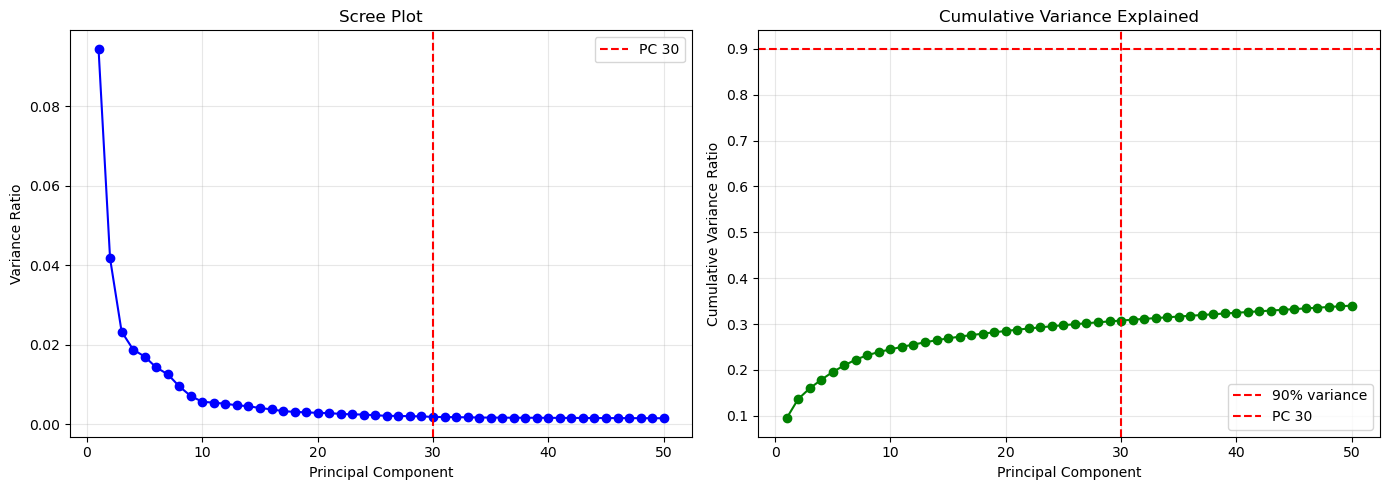

In [31]:
# Elbow plot - variance ratio per PC
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Variance explained by each PC
axes[0].plot(range(1, 51), adata.uns['pca']['variance_ratio'], 'bo-')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Ratio')
axes[0].set_title('Scree Plot')
axes[0].axvline(x=30, color='r', linestyle='--', label='PC 30')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative variance explained
cumsum_var = np.cumsum(adata.uns['pca']['variance_ratio'])
axes[1].plot(range(1, 51), cumsum_var, 'go-')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Cumulative Variance Ratio')
axes[1].set_title('Cumulative Variance Explained')
axes[1].axhline(y=0.9, color='r', linestyle='--', label='90% variance')
axes[1].axvline(x=30, color='r', linestyle='--', label='PC 30')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Compute Neighborhood Graph

### k-Nearest Neighbors (kNN) Graph
- Connects each cell to its k nearest neighbors in PC space
- Foundation for clustering and UMAP
- Default: k=15 neighbors, using 30-50 PCs

In [32]:
# Compute neighborhood graph using 30 PCs
n_pcs = 30

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=n_pcs)

2026-01-08 22:42:16.458745: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-08 22:42:17.094065: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-08 22:42:19.065587: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [33]:
adata

AnnData object with n_obs × n_vars = 5172 × 1580
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [34]:
adata.uns

{'hvg': {'flavor': 'seurat'},
 'log1p': {'base': None},
 'pca': {'params': {'zero_center': True,
   'use_highly_variable': True,
   'mask_var': 'highly_variable'},
  'variance': array([137.44926781,  60.7074248 ,  33.93416282,  27.35746673,
          24.7809636 ,  20.81375557,  18.31762132,  13.89155485,
          10.31926511,   8.25872028,   7.90218366,   7.5309891 ,
           6.94270558,   6.62110259,   5.93735679,   5.48151351,
           4.80290284,   4.55079842,   4.35325134,   4.19983611,
           4.08260797,   3.79949589,   3.63188935,   3.57185884,
           3.29203984,   3.09822266,   3.05455351,   2.9542029 ,
           2.90700269,   2.68514456,   2.66109028,   2.59265613,
           2.554098  ,   2.48388343,   2.45291919,   2.43151424,
           2.39577265,   2.39212552,   2.38466489,   2.35985933,
           2.34226965,   2.32783471,   2.31257862,   2.28612985,
           2.27248463,   2.26543958,   2.25039311,   2.237923  ,
           2.22942202,   2.21019106]),
  'va

## UMAP Visualization

### What is UMAP?
- **U**niform **M**anifold **A**pproximation and **P**rojection
- Non-linear dimensionality reduction
- Projects high-dimensional data to 2D/3D
- Preserves local and global structure better than t-SNE
- Faster than t-SNE for large datasets

In [2]:
sc.tl.umap(adata, min_dist=0.5, spread=1.0)

NameError: name 'sc' is not defined

In [36]:
adata

AnnData object with n_obs × n_vars = 5172 × 1580
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

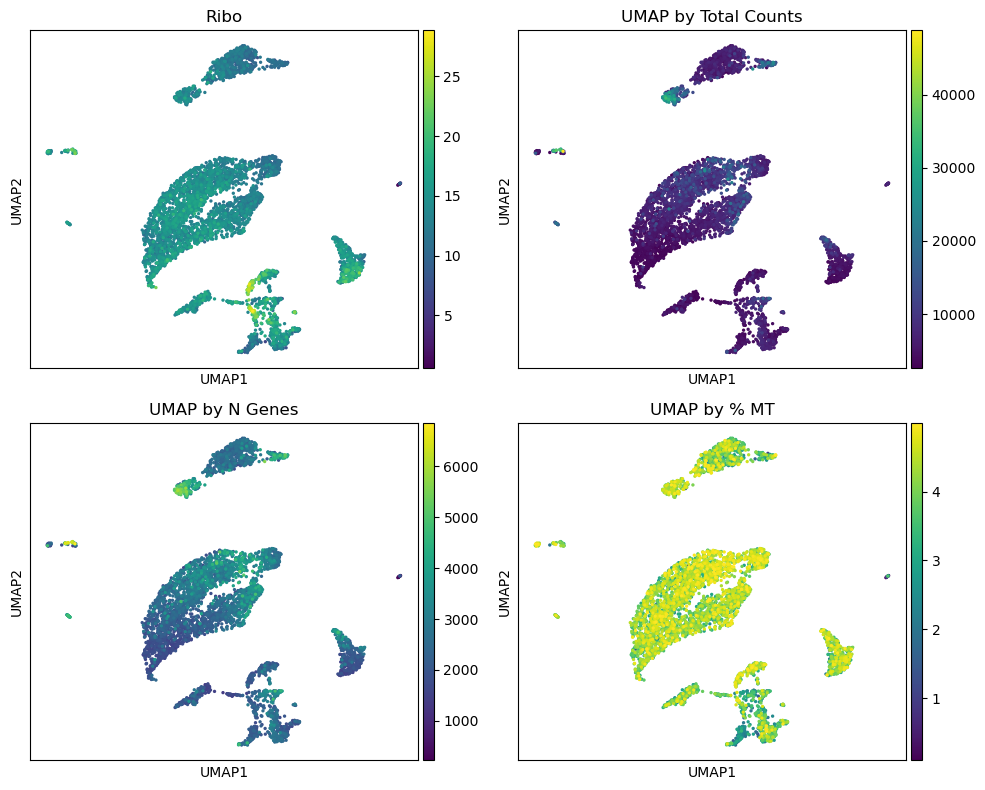

In [37]:
# Visualize UMAP
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# By sample
sc.pl.umap(adata, color='pct_counts_ribo', ax=axes[0, 0], show=False,
           title='Ribo')

# By total counts
sc.pl.umap(adata, color='total_counts', ax=axes[0, 1], show=False,
           title='UMAP by Total Counts', cmap='viridis')

# By n_genes
sc.pl.umap(adata, color='n_genes_by_counts', ax=axes[1, 0], show=False,
           title='UMAP by N Genes', cmap='viridis')

# By pct_counts_mt
sc.pl.umap(adata, color='pct_counts_mt', ax=axes[1, 1], show=False,
           title='UMAP by % MT', cmap='viridis')

plt.tight_layout()
plt.show()

In [1]:
!rocm-smi




========================================= ROCm System Management Interface =========================================
=================================================== Concise Info ===================================================
Device  Node  IDs              Temp    Power     Partitions          SCLK  MCLK     Fan  Perf  PwrCap  VRAM%  GPU%  
              (DID,     GUID)  (Edge)  (Socket)  (Mem, Compute, ID)                                                 
0       1     0x1638,   21821  31.0°C  12.0W     N/A, N/A, 0         N/A   1600Mhz  0%   auto  N/A     84%    3%    
=============================================== End of ROCm SMI Log ================================================
